In [1]:
!pip install keras
!pip install livelossplot


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

import tensorflow as tf
tf.__version__

'2.3.1'

In [3]:
for expression in os.listdir('train/'):
    print(str(len(os.listdir('train/'+expression)))+' '+expression+' images')

3995 angry images
436 disgust images
4097 fear images
7214 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [23]:
for expression in os.listdir('test/'):
    print(str(len(os.listdir('test/'+expression)))+' '+expression+' images')

958 angry images
111 disgust images
1024 fear images
1774 happy images
1233 neutral images
1247 sad images
831 surprise images


# Training and Testing Data Generator 

In [24]:
#parameters for dataloader
image_size=48
batch_size=64

#data loader for trainset
datagenerator_train=ImageDataGenerator(horizontal_flip=True) #data augmentation: flip images along horizontal axis 
train_generator=datagenerator_train.flow_from_directory('train/',target_size=(48,48),color_mode='grayscale',batch_size=64,
                                                       class_mode='categorical',shuffle=True)

#data loader for testset 
datagenerator_test=ImageDataGenerator(horizontal_flip=True) #data augmentation: flip images along horizontal axis 
test_generator=datagenerator_test.flow_from_directory('test/',target_size=(48,48),color_mode='grayscale',batch_size=64,
                                                       class_mode='categorical',shuffle=True)

#one hot encoding the category 

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model 

In [25]:
model=Sequential()

#1st Convolution Layer
#same padding, so dont lose information on image 
#1st layer, needs input_shape
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd Convolution Layer
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd Convolution Layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th Convolution Layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#1st fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#2nd fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#create output
#dense layer
model.add(Dense(7,activation='softmax'))

optimize =Adam(lr=0.0005)
model.compile(optimizer=optimize,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

# Train and Evaluate Model

In [35]:
tf.config.experimental.list_physical_devices('GPU') 

[]

In [36]:
tf.keras

<module 'tensorflow.keras' from 'C:\\Users\\fiona\\.conda\\envs\\tfgpu\\lib\\site-packages\\tensorflow\\keras\\__init__.py'>

In [28]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [34]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 392719465195178570
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 796703226727290711
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7015332946118297379
physical_device_desc: "device: XLA_GPU device"
]


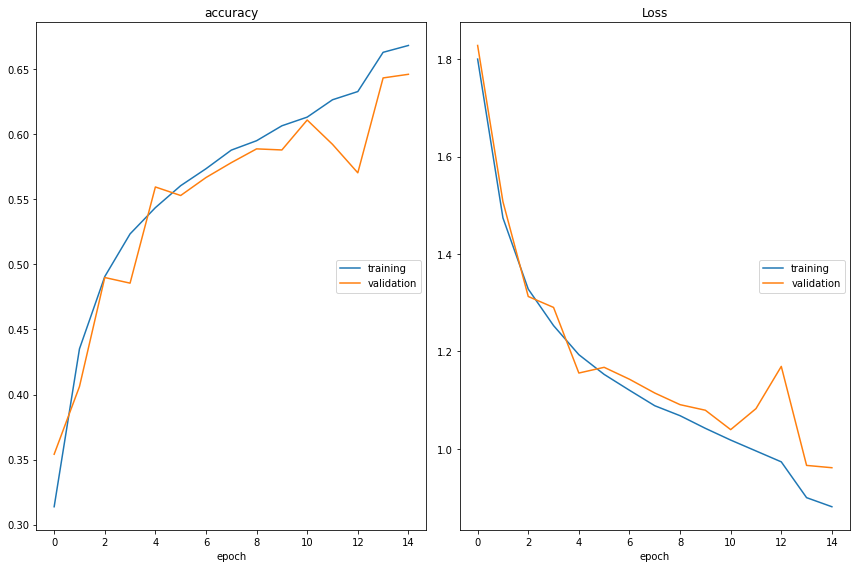

accuracy
	training         	 (min:    0.314, max:    0.668, cur:    0.668)
	validation       	 (min:    0.354, max:    0.646, cur:    0.646)
Loss
	training         	 (min:    0.881, max:    1.800, cur:    0.881)
	validation       	 (min:    0.961, max:    1.828, cur:    0.961)

Epoch 00015: saving model to model_weight.h5
448/448 [==============================] - 480s 1s/step - loss: 0.8809 - accuracy: 0.6684 - val_loss: 0.9610 - val_accuracy: 0.6462


In [30]:
epochs=15 #based on learning rate and batch size
train_process_per_epoch= train_generator.n//train_generator.batch_size #number of pictures/batch size
test_process_per_epoch= test_generator.n//test_generator.batch_size

# define callbacks 
#save model weights with the highest accuracy 
checkpoint=ModelCheckpoint('model_weight.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_weights_only=True,
                             verbose=1)

#learning rate scheduler 
lr_new=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,mode='auto',min_lr=0.00001)

callbacks=[PlotLossesKeras(),checkpoint,lr_new]

training=model.fit(x=train_generator,steps_per_epoch=train_process_per_epoch,callbacks=callbacks,validation_data=test_generator,
                   validation_steps=test_process_per_epoch,epochs=epochs)




